**Check Python Version**

**Install pytorch and torchvision**

In [12]:
import numpy as np
import time
import os
import copy
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import matplotlib.pyplot as plt

print('PyTorch version:', torch.__version__)
device='cpu'

PyTorch version: 1.0.0


**Data Augmentation**

In [2]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),      
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
     ]),
    
    'valid' : transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])
}

transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),      
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
     ])

In [4]:
venice_traindata_path = "../drive-data/venice_traindata"
venice_traindata = ([name for name in os.listdir(venice_traindata_path) if os.path.isdir(os.path.join(venice_traindata_path, name))]) # get all directories

for folder in venice_traindata:
    contents = os.listdir(os.path.join(venice_traindata_path,folder))
    print(folder, ":", len(contents))

Gondola : 24
Topa : 78
Mototopo : 878
Ambulanza : 85
Lanciafino10mMarrone : 355
Lanciafino10m : 22
VaporettoACTV : 949
MotoscafoACTV : 11
Lanciafino10mBianca : 484
Raccoltarifiuti : 94
Sandoloaremi : 13
Polizia : 71
Patanella : 279
Lanciamaggioredi10mBianca : 9
Motobarca : 215
Alilaguna : 113
Barchino : 112
Motopontonerettangolare : 18


In [5]:
venice_testdata_path = "../drive-data/classified_venice_testdata"
venice_testdata = ([name for name in os.listdir(venice_testdata_path) if os.path.isdir(os.path.join(venice_testdata_path, name))])

for folder in venice_testdata:
    contents = os.listdir(os.path.join(venice_testdata_path,folder))
    print(folder, ":", len(contents))

Gondola : 3
Topa : 29
Mototopo : 284
Ambulanza : 22
Lanciafino10mMarrone : 125
Lanciafino10m : 7
VaporettoACTV : 325
MotoscafoACTV : 1
Lanciafino10mBianca : 217
Raccoltarifiuti : 19
Sandoloaremi : 3
Polizia : 15
Patanella : 74
Lanciamaggioredi10mBianca : 6
Motobarca : 59
Alilaguna : 19
Barchino : 51
Motopontonerettangolare : 3


In [6]:
train_dir = 'train'
valid_dir = 'valid'


dirs = {'train': '../drive-data/venice_traindata', 
        'valid': '../drive-data/classified_venice_testdata'}

image_datasets = {x: torchvision.datasets.ImageFolder(dirs[x], transform=data_transforms[x]) for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=380, shuffle=True) for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid']}

train_class_names = image_datasets['train'].classes
valid_class_names = image_datasets['valid'].classes
print(train_class_names)
print(len(train_class_names))
print(len(valid_class_names))


['Alilaguna', 'Ambulanza', 'Barchino', 'Gondola', 'Lanciafino10m', 'Lanciafino10mBianca', 'Lanciafino10mMarrone', 'Lanciamaggioredi10mBianca', 'Motobarca', 'Motopontonerettangolare', 'MotoscafoACTV', 'Mototopo', 'Patanella', 'Polizia', 'Raccoltarifiuti', 'Sandoloaremi', 'Topa', 'VaporettoACTV']
18
18


In [7]:
def train_model(model, criteria, optimizer, scheduler,    
                                      num_epochs=25):
    model.to(device='cpu') 
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [15]:
# Convolutional neural network (three convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1)
        
        self.softmaxlog = nn.LogSoftmax(dim=1)
        self.fc1 = nn.Linear(24*128*128,1024)
        self.fc2 = nn.Linear(1024,num_classes)
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        
        output = self.pool(output)
        
        output = self.conv3(output)
        output = self.softmaxlog(output)
        output = output.reshape(output.size(0), 24*128*128)
        output = self.fc1(output)
        output = self.fc2(output)
        return output
    
cnn_model = ConvNet(18).to(device)
print(cnn_model)


ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (softmaxlog): LogSoftmax()
  (fc1): Linear(in_features=393216, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=18, bias=True)
)


In [9]:
def get_random_images(num):
    data = image_datasets['train']
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [16]:
def predict_image(image):
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = cnn_model(input)
    index = output.data.cpu().numpy().argmax()
    return index


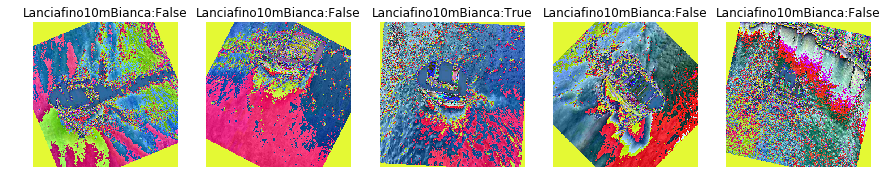

In [17]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(15,15))
classes = image_datasets['train'].classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()


In [6]:
# Criteria NLLLoss which is recommended with Softmax final layer
loss_function = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(cnn_model.parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 4 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

# Number of epochs
eps=10

# train our model
cnn_model_fit = train_model(cnn_model, loss_function, optimizer, scheduler, eps)


Epoch 0/9
----------
train Loss: 142632.1629 Acc: 0.1364
valid Loss: 175748.1220 Acc: 0.2250

Epoch 1/9
----------
train Loss: 155223.9026 Acc: 0.1301
valid Loss: 198915.7109 Acc: 0.0151

Epoch 2/9
----------
train Loss: 130088.5543 Acc: 0.1217
valid Loss: 115959.4546 Acc: 0.1719

Epoch 3/9
----------
train Loss: 200772.9771 Acc: 0.1632
valid Loss: 255217.5220 Acc: 0.0586

Epoch 4/9
----------
train Loss: 208414.6154 Acc: 0.0617
valid Loss: 80981.4158 Acc: 0.1719

Epoch 5/9
----------
train Loss: 83964.5619 Acc: 0.1942
valid Loss: 54710.9347 Acc: 0.2250

Epoch 6/9
----------
train Loss: 61870.8145 Acc: 0.1035
valid Loss: 27993.2469 Acc: 0.2250

Epoch 7/9
----------
train Loss: 42223.1433 Acc: 0.1337
valid Loss: 40278.3125 Acc: 0.0230

Epoch 8/9
----------
train Loss: 44762.8508 Acc: 0.0360
valid Loss: 27460.8409 Acc: 0.2575

Epoch 9/9
----------
train Loss: 35338.7896 Acc: 0.2294
valid Loss: 22339.8433 Acc: 0.0174

Training complete in 111m 34s
Best val Acc: 0.257528


In [24]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # input channel = 3, output channel = 16, kernel_size = 5
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 61 * 61, 500) # 32* 61*61
        self.fc2 = nn.Linear(500, 18)
  
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
      
lenet_model = LeNet()
print(lenet_model)

# Criteria NLLLoss which is recommended with Softmax final layer
loss_function = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(lenet_model.parameters(), lr=0.01, momentum=0.5)

# Decay LR by a factor of 0.1 every 4 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

# Number of epochs
eps=10

# train our model
lenet_model_fit = train_model(lenet_model, loss_function, optimizer, scheduler, eps)


LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=119072, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=18, bias=True)
)
Epoch 0/9
----------
train Loss: 2.0781 Acc: 0.3424
valid Loss: 2.0597 Acc: 0.3788

Epoch 1/9
----------
train Loss: 1.7445 Acc: 0.4966
valid Loss: 1.9054 Acc: 0.3938

Epoch 2/9
----------
train Loss: 1.9833 Acc: 0.4383
valid Loss: 1.8598 Acc: 0.4667

Epoch 3/9
----------
train Loss: 1.6361 Acc: 0.5108
valid Loss: 1.8352 Acc: 0.5119

Epoch 4/9
----------
train Loss: 1.5643 Acc: 0.5297
valid Loss: 1.8543 Acc: 0.5578

Epoch 5/9
----------
train Loss: 1.5249 Acc: 0.5420
valid Loss: 1.8444 Acc: 0.5571

Epoch 6/9
----------
train Loss: 1.5078 Acc: 0.5470
valid Loss: 1.8259 Acc: 0.5507

Epoch 7/9
----------
train Loss: 1.5087 Acc: 0.5397
valid Loss: 1.8261 Acc: 0.5515

Epoch 8/9
----------
train Loss: 1.4902 Acc: 0.5468
valid Loss: 1.8233 A

In [28]:
def predict_image(image):
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = lenet_model(input)
    index = output.data.cpu().numpy().argmax()
    return index


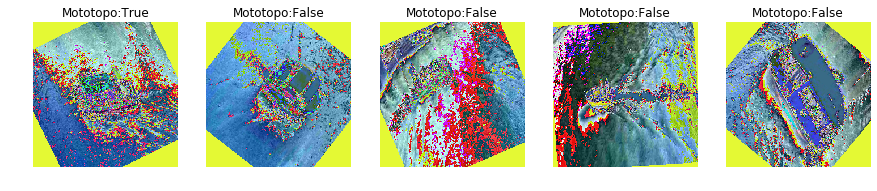

In [30]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(15,15))
classes = image_datasets['train'].classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()


In [31]:
# AlexNet
class AlexNet(nn.Module):
    def __init__(self, num_classes=18):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 7 * 7)
        x = self.classifier(x)
        return x
    
alexnet_model = AlexNet(18).to(device)
print(alexnet_model)

# Criteria NLLLoss which is recommended with Softmax final layer
loss_function = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(alexnet_model.parameters(), lr=0.01, momentum=0.5)

# Decay LR by a factor of 0.1 every 4 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

# Number of epochs
eps=10

# train our model
alexnet_model_fit = train_model(alexnet_model, loss_function, optimizer, scheduler, eps)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=12544, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_featur

In [34]:
def predict_image(image):
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = alexnet_model_fit(input)
    index = output.data.cpu().numpy().argmax()
    return index


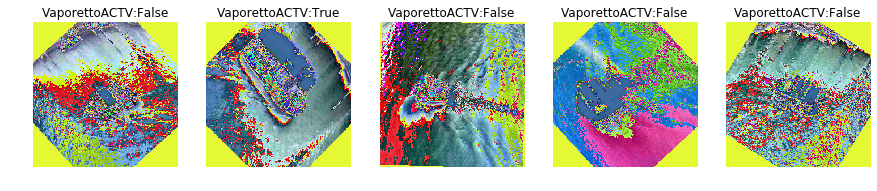

In [35]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(15,15))
classes = image_datasets['train'].classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()